In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from transformers import SwinForImageClassification

from sklearn.metrics import confusion_matrix, classification_report
import timm

In [22]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths and parameters
data_dir = './../../dataset/raw_data/train'  # Your dataset path (5 subfolder classes)
run_folder = 'results/run3'        # Results folder (run1, run2,... etc.)
batch_size = 16
num_epochs = 10
image_size = 224  # Input size for Swin Transformer

# Ensure run_folder exists
if not os.path.exists(run_folder):
    os.makedirs(run_folder)

In [23]:
# Transformations: Random crop for training, Resize for validation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    #transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
# Load the dataset
dataset = datasets.ImageFolder(root=data_dir)

# Ensure the dataset classes are in the correct order (1, 2, 3, 4, 5)
dataset.classes.sort(key=lambda x: int(x))  # Sort the class names numerically if they are numeric strings

# Create a mapping from numerical labels to class names
label_to_class_name = {idx: class_name for idx, class_name in enumerate(dataset.classes)}

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Assign transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [25]:
# class CustomSwinTransformer(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomSwinTransformer, self).__init__()
#         self.swin_transformer = create_model('swin_tiny_patch4_window7_224', pretrained=True)
#         # Replace the last layer for your specific task
#         self.swin_transformer.head = nn.Linear(self.swin_transformer.head.in_features, num_classes)
#         self.layer_norm = nn.LayerNorm(normalized_shape=num_classes)

#     def forward(self, x):
#         x = self.swin_transformer(x)
#         return self.layer_norm(x)  # Apply layer normalization
# model = CustomSwinTransformer(num_classes=len(train_dataset.classes))
# model.to(device)

In [42]:
# Define the Swin transformer model
model = timm.create_model('efficientnet_b1', pretrained=True, num_classes=5)

model.to(device)

#class_counts = [414,478,856,1034,426] # aug-mix
class_counts = [282,320,575,700,298]

total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)


In [43]:
# Track training history
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

Epoch 1/10, Train Loss: 3.5027, Train Acc: 27.64%, Val Loss: 2.7347, Val Acc: 34.48%


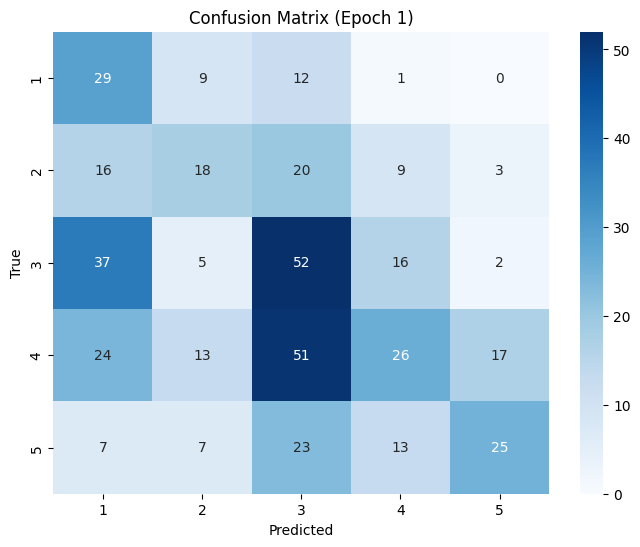

Epoch 2/10, Train Loss: 1.5500, Train Acc: 51.84%, Val Loss: 2.3334, Val Acc: 42.53%


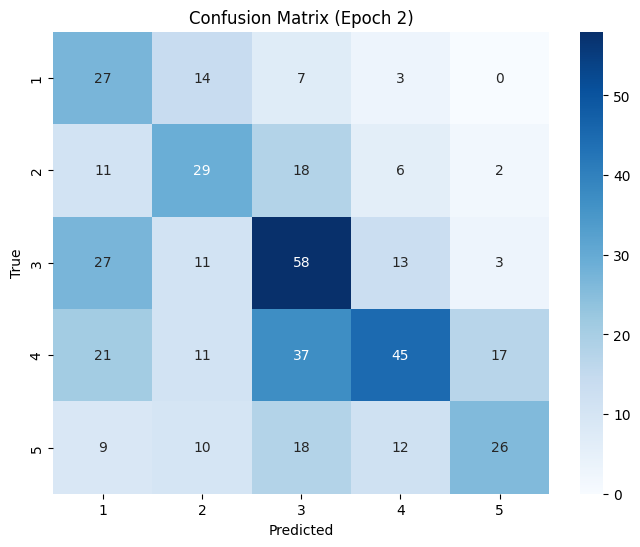

Epoch 3/10, Train Loss: 0.8869, Train Acc: 66.21%, Val Loss: 2.1589, Val Acc: 44.83%


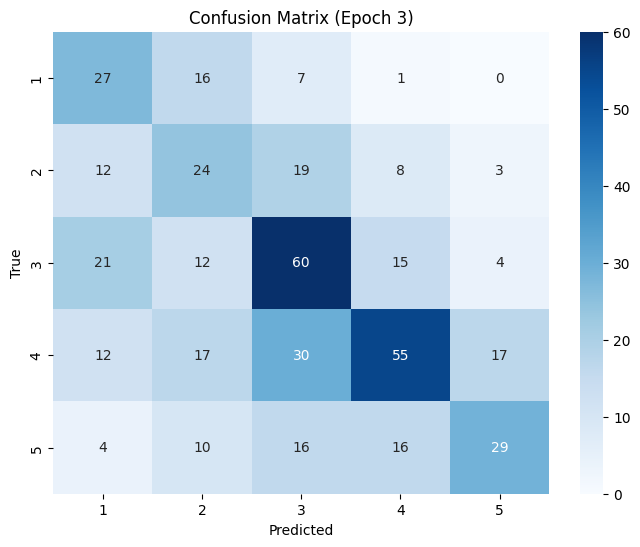

Epoch 4/10, Train Loss: 0.5672, Train Acc: 77.47%, Val Loss: 2.2383, Val Acc: 44.83%


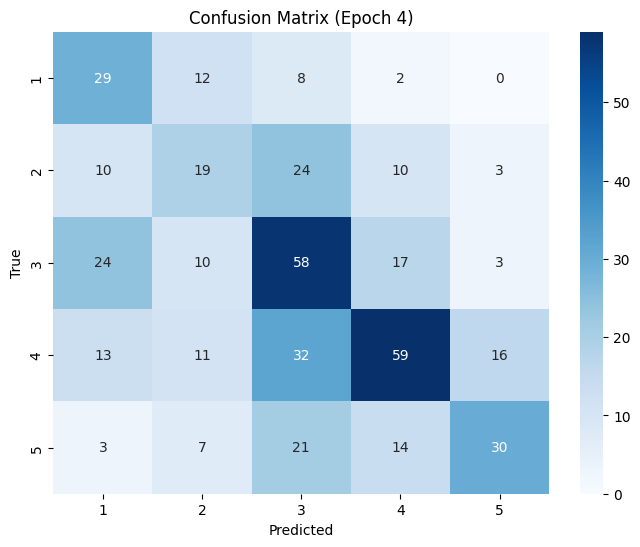

Epoch 5/10, Train Loss: 0.3648, Train Acc: 85.00%, Val Loss: 2.2380, Val Acc: 50.80%
Early stopping triggered after 5 epochs.


In [44]:
# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 2  # Number of epochs to wait for improvement
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
        # Optionally, save the best model here
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

    # Confusion matrix for validation set
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Epoch {epoch + 1})')
    plt.show()

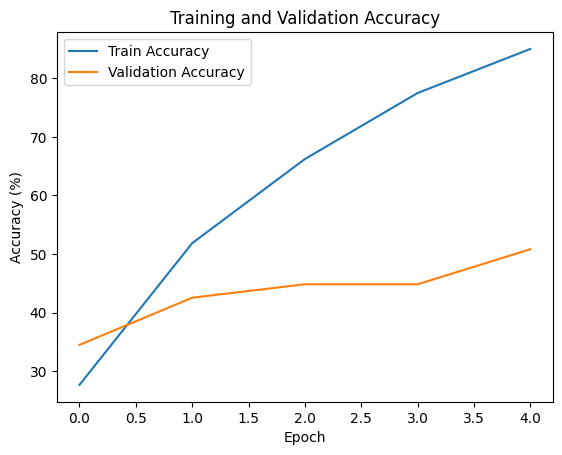

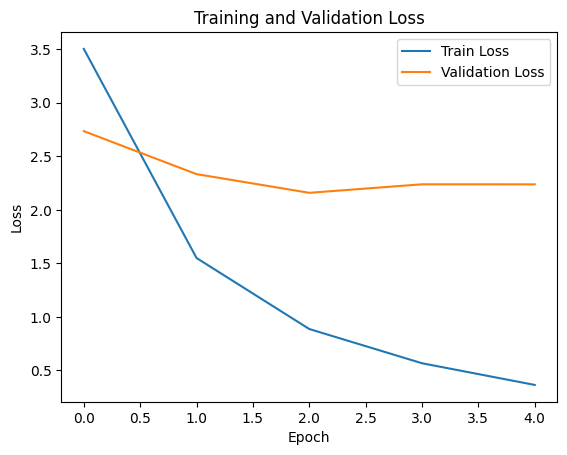

Accuracy and loss graphs saved to results/run3


In [46]:
# Plot accuracy and loss graphs
plt.figure()
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# plt.savefig(os.path.join(run_folder, 'accuracy_lr7.png'))
# plt.close()

plt.figure()
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

#plt.savefig(os.path.join(run_folder, 'loss_lr7.png'))
# plt.close()

plt.show()
print(f'Accuracy and loss graphs saved to {run_folder}')

In [47]:
# Final classification report after all epochs
print("Final Classification Report:")
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print(report)

Final Classification Report:
              precision    recall  f1-score   support

           1       0.42      0.53      0.47        51
           2       0.41      0.36      0.39        66
           3       0.48      0.56      0.52       112
           4       0.59      0.59      0.59       131
           5       0.61      0.40      0.48        75

    accuracy                           0.51       435
   macro avg       0.50      0.49      0.49       435
weighted avg       0.52      0.51      0.51       435



In [48]:
# Save the classification report to a text file
report_path = os.path.join(run_folder, 'cls_report_effnet.txt')
with open(report_path, 'w') as f:
    f.write(report)

print(f"Classification report saved to {report_path}.")

Classification report saved to results/run3/cls_report_effnet.txt.


In [49]:
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:\n", cm)

# Check if the confusion matrix is not blank (contains any non-zero values)
if cm.sum() > 0:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                 xticklabels=dataset.classes, 
                 yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Epoch {epoch + 1})')
    # Save the confusion matrix plot
    plt.savefig(os.path.join('cls_report_eff_net.png'), bbox_inches='tight')
    plt.close()  # Close the figure to free memory
else:
    print("Confusion matrix is blank. Not saving.")

Confusion Matrix:
 [[27 13  8  3  0]
 [10 24 17 10  5]
 [17  8 63 22  2]
 [ 8  9 25 77 12]
 [ 3  4 19 19 30]]


In [67]:
# Save model weights
model_save_path = os.path.join(run_folder, 'swin_effnet.pth')
torch.save(model.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

Model weights saved to results/run3/swin_run-lr7.pth


## test

In [68]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
import torchvision.models as models

In [69]:
# Load the trained model (make sure it's in evaluation mode)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_path = run_folder + '/swin_run-augmix.pth'

# Define the Swin transformer model
model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-base-patch4-window7-224',
    num_labels=5,
    ignore_mismatched_sizes=True
)

model.load_state_dict(torch.load(weights_path))

model.to(device).eval()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1766339/2716394293.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fl

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO

In [70]:

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Directory containing test images
test_dir = './../../dataset/test'
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

In [71]:
# Sort filenames to ensure correct order
test_images.sort(key=lambda x: int(os.path.splitext(x)[0]))  # Assuming filenames are numeric

# Initialize lists to store filenames and predictions
filenames = []
predictions = []

# Process each image in the test directory
for image_name in test_images:
    image_path = os.path.join(test_dir, image_name)
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    image = test_transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Predict the class
    with torch.no_grad():
        outputs = model(image)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        class_id = predicted.item()

    # Save results
    filenames.append(os.path.splitext(image_name)[0])  # Remove .jpg from filename
    predictions.append(class_id + 1)  # Map class_id to 1-based index if needed

In [72]:
# Save results to a CSV file
results_df = pd.DataFrame({'ID': filenames, 'Predictions': predictions})
results_df.to_csv('swin-lr7.csv', index=False)